In [1]:
#CNN CIFAR10 정확도 높이기
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import random_split
from torch.utils.data import Dataset, DataLoader

device= torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

train_dataset=datasets.CIFAR10(root="CIFAR10_data/", train=True, download=True,
                            transform=transforms.ToTensor())

test_dataset=datasets.CIFAR10(root="CIFAR10_data/", train=False, download=True,
                           transform=transforms.ToTensor())

train_dataset_size=int(len(train_dataset)*0.85)
validation_dataset_size=int(len(train_dataset)*0.15)

train_dataset, validation_dataset=random_split(train_dataset,[train_dataset_size,validation_dataset_size])

print(len(train_dataset), len(validation_dataset), len(test_dataset))

c:\Users\ANNA_TEST\anaconda3\Lib\site-packages\torch\cuda\__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]
100%|██████████| 170M/170M [01:00<00:00, 2.82MB/s] 


42500 7500 10000


In [ ]:
BATCH_SIZE=32

train_dataset_loader=DataLoader(dataset=train_dataset,batch_size=BATCH_SIZE, shuffle=True)
validation_dataset_loader=DataLoader(dataset=validation_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataset_loader=DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [3]:
class MyCNNModel(nn.Module):

    def __init__(self):

        super().__init__()
        self.conv1=nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2=nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.conv3=nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv4=nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.conv5=nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv6=nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.conv7=nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)

        self.pooling=nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1=nn.Linear(1*1*256,128)
        self.fc2=nn.Linear(128,10)

        self.dropout25=nn.Dropout(p=0.25)
        self.dropout50=nn.Dropout(p=0.50)

    def forward(self,data):
        data=self.conv1(data)
        data=torch.relu(data)
        data=self.conv2(data)
        data=torch.relu(data)
        data=self.pooling(data)
        data=self.dropout25(data)

        data=self.conv3(data)
        data=torch.relu(data)
        data=self.conv4(data)
        data=torch.relu(data)
        data=self.pooling(data)
        data=self.dropout25(data)

        data=self.conv5(data)
        data=torch.relu(data)
        data=self.pooling(data)
        data=self.dropout25(data)

        data=self.conv6(data)
        data=torch.relu(data)
        data=self.pooling(data)
        data=self.dropout25(data)

        data=self.conv7(data)
        data=torch.relu(data)
        data=self.pooling(data)
        data=self.dropout25(data)

        data=data.view(-1,1*1*256)

        data=self.fc1(data)
        data=torch.relu(data)
        data=self.dropout50(data)

        logits=self.fc2(data)

        return logits


In [ ]:
model=MyCNNModel().to(device)

loss_function=nn.CrossEntropyLoss()

optimizer=torch.optim.Adam(model.parameters(), lr=1e-3)

In [4]:
def model_train(dataloader, model, loss_function, optimizer):

    model.train()

    train_loss_sum=train_correct=train_total=0

    total_train_batch=len(dataloader)

    for images, labels in dataloader:

        x_train=images.to(device)
        y_train=labels.to(device)

        outputs=model(x_train)
        loss=loss_function(outputs, y_train)
                                                                                                       
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss_sum+=loss.item()

        train_total+=y_train.size(0)
        train_correct+=((torch.argmax(outputs, 1)==y_train)).sum().item()

    train_avg_loss=train_loss_sum/total_train_batch
    train_avg_accuracy=100*train_correct/train_total

    return (train_avg_loss, train_avg_accuracy)

def model_evaluate(dataloader, model,loss_function, optimizer):

    model.eval()

    with torch.no_grad():

        val_loss_sum=val_correct=val_total=0

        total_val_batch=len(dataloader)

        for images, labes in dataloader:

            x_val=images.to(device)
            y_val=labes.to(device)

            outputs=model(x_val)
            loss=loss_function(outputs, y_val)

            val_loss_sum+=loss.item()

            val_total+=y_val.size(0)
            val_correct+=((torch.argmax(outputs,1)==y_val)).sum().item()

        val_avg_loss=val_loss_sum/total_val_batch
        val_avg_accuracy=100*val_correct/val_total

    return (val_avg_loss, val_avg_accuracy)

def model_test(dataloader, model):

    model.eval()

    with torch.no_grad():

        test_loss_sum=test_correct=test_total=0

        total_test_batch=len(dataloader)

        for images, labels in dataloader:

            x_test=images.to(device)
            y_test=labels.to(device)

            outputs=model(x_test)
            loss=loss_function(outputs, y_test)

            test_loss_sum+=loss.item()

            test_total+=y_test.size(0)
            test_correct+=((torch.argmax(outputs,1)==y_test)).sum().item()

        test_avg_loss=test_loss_sum/total_test_batch
        test_avg_accuracy=100*test_correct/test_total

    return (test_avg_loss, test_avg_accuracy)

In [6]:
train_loss_list=[]
train_accuracy_list=[]

val_loss_list=[]
val_accuracy_list=[]

EPOCH=20

for epoch in range(EPOCH):

    train_avg_loss,train_avg_accuracy=model_train(train_dataset_loader,model, loss_function, optimizer)

    train_loss_list.append(train_avg_loss)
    train_accuracy_list.append(train_avg_accuracy)

    val_avg_loss, val_avg_accuracy=model_evaluate(validation_dataset_loader,model, loss_function, optimizer)

    val_loss_list.append(val_avg_loss)
    val_accuracy_list.append(val_avg_accuracy)

    print(f'epoch:{epoch},train loss:{train_avg_loss}, train accuracy:{train_avg_accuracy}, val loss:{val_avg_loss}, val accuracy:{val_avg_accuracy}')

epoch:0,train loss:2.3032971190903937, train accuracy:9.83529411764706, val loss:2.305609150135771, val accuracy:9.72
epoch:1,train loss:2.075162354764228, train accuracy:21.04705882352941, val loss:1.8022100088444162, val accuracy:30.16
epoch:2,train loss:1.7746619292898587, train accuracy:32.92, val loss:1.5927216798701185, val accuracy:40.306666666666665
epoch:3,train loss:1.6492725179731802, train accuracy:38.56235294117647, val loss:1.4461590594433724, val accuracy:45.986666666666665
epoch:4,train loss:1.5498957891406826, train accuracy:43.129411764705885, val loss:1.3767672893848826, val accuracy:49.28
epoch:5,train loss:1.4641286949182113, train accuracy:46.70823529411765, val loss:1.3017844403043706, val accuracy:52.50666666666667
epoch:6,train loss:1.4021996374054901, train accuracy:49.32, val loss:1.194970628302148, val accuracy:56.413333333333334
epoch:7,train loss:1.3453609209207775, train accuracy:51.567058823529415, val loss:1.1317329774511622, val accuracy:59.41333333333

In [7]:
test_loss,test_accuracy=model_test(test_dataset_loader,model)

print(f'accuracy: {test_accuracy}')
print(f'loss: {test_loss}')

accuracy: 67.5
loss: 0.9173609313492577


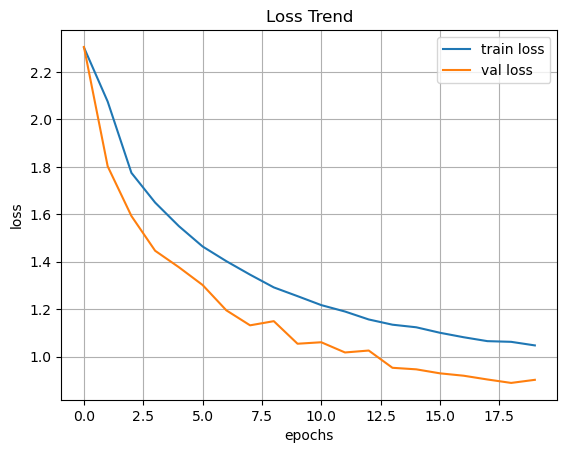

In [8]:
import matplotlib.pyplot as plt

plt.title("Loss Trend")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(train_loss_list, label="train loss")
plt.plot(val_loss_list, label="val loss")
plt.legend(loc='best')

plt.show()

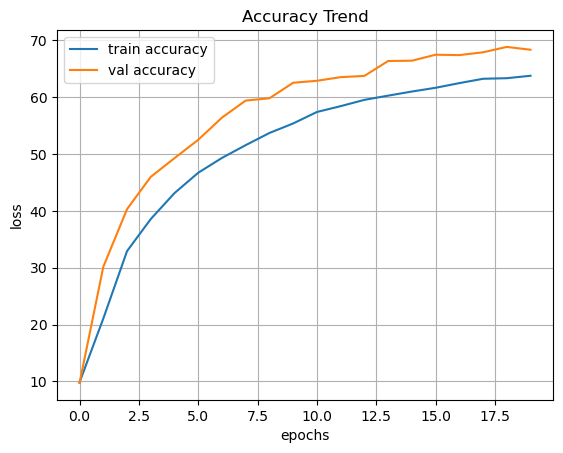

In [9]:
plt.title("Accuracy Trend")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(train_accuracy_list, label="train accuracy")
plt.plot(val_accuracy_list, label="val accuracy")
plt.legend(loc='best')

plt.show()

In [10]:
import torch
from torchvision import models

pretrained_model=models.vgg16(weights=models.VGG16_Weights.DEFAULT)

print(pretrained_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [11]:
class MyTransferLearningModel(torch.nn.Module):

    def __init__(self,pretrained_model, feature_extractor):
        super().__init__()

        if ( feature_extractor):
            for param in pretrained_model.parameters():
                param.require_grad=False

        pretrained_model.classifier=torch.nn.Sequential(
            torch.nn.Linear(pretrained_model.classifier[0].in_features, 128),
            torch.nn.Linear(128,2)
        )

        self.model=pretrained_model

    def forward(self, data):
        logits=self.model(data)
        return logits 

In [12]:
feature_extractor=True 
model=MyTransferLearningModel(pretrained_model, feature_extractor)
optimizer= torch.optim.Adam(model.parameters(), lr=1e-6)

loss_function=torch.nn.CrossEntropyLoss()